In [1]:
import os
import sys
import logging
import lmfit as lm
# import glob
# import time
# import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Custom packages
import iXAtom_Class_Physics       as iXC_Physics
import iXAtom_Class_RunParameters as iXC_RunPars
import iXAtom_Class_Detector      as iXC_Detect
import iXAtom_Class_Ramsey        as iXC_Ramsey
import iXAtom_Utilities           as iXUtils

# For inline plots
%matplotlib inline
# Reload IPython extension 'autoreload'
%reload_ext autoreload
# autoreload: Reload all modules (except those excluded by %aimport) automatically now
# autoreload 0: Disable automatic reloading of modules
# autoreload 1: Reload all modules imported with %aimport every time before executing
# autoreload 2: Reload all modules (except those excluded by %aimport) every time before executing
%autoreload 1

%aimport iXAtom_Class_Physics
%aimport iXAtom_Class_RunParameters
%aimport iXAtom_Class_Detector
%aimport iXAtom_Class_Ramsey
%aimport iXAtom_Utilities

logging.disable(level=logging.NOTSET)

iXUtils.SetDefaultPlotOptions()

In [2]:
# RootDir = 'C:\\Bryns Goodies\\Work-iXAtom\\Data 2020'
RootDir = 'C:\\iXAtom Desktop\\Data 2020'
Date    = {'Month': 'August', 'Day': 10}
WorkDir = os.path.join(RootDir, Date['Month'], '{:02d}'.format(Date['Day']))
Folder  = 'Raman'
RunNum  = 1

RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunNum)
RunPars.LoadRunParameters()

Physics = iXC_Physics.Physics(RunPars)
keff    = RunPars.keff
gLocal  = RunPars.gLocal
ikList  = RunPars.ikList
iaxList = RunPars.iaxList

pd.DataFrame(RunPars.__dict__.items())

,0,1
0,SoftwareVersion,3.3
1,Run,1
2,DataType,Raman
3,TrackProtocol,Two-Point kInterlaced
4,TrackMode,"Open Loop, Fixed Chirp"
...,...,...
94,nk,2
95,nax,1
96,FilePrefix,Raman
97,AxisFileLabels,"[[X-kU, X-kD], [Y-kU, Y-kD], [Z-kU, Z-kD]]"


In [3]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [#{'Month': 'August', 'Day': 10},
            {'Month': 'August', 'Day': 14}, {'Month': 'August', 'Day': 14}]
RunLists = [#[1,7],
            [19,31], [20,32]]

Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet']]
nSummary = len(RunLists)
PRaman   = np.zeros(nSummary)

SummaryDF = [[pd.DataFrame([]) for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, 'Rabi', RunList[0])
    RunPars.LoadRunParameters()
    PRaman[s] = RunPars.RamanPower
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', 'Rabi')
    SummaryFilePrefix = 'Rabi-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][0]+'.txt')
        if os.path.exists(SummaryFilePath):
            print('Loading summary file: {}'.format(SummaryFilePath))
            SummaryDF[s][iax] = pd.read_csv(SummaryFilePath, sep='\t')
            SummaryDF[s][iax].sort_values(by=['RamanPower'], inplace=True)
        else:
            print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\14\PostProcessed\Rabi\Rabi-Runs19-31-AnalysisSummary-Z.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\14\PostProcessed\Rabi\Rabi-Runs20-32-AnalysisSummary-Z.txt


----------- Fit Results (s = 0) -----------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 7
    # variables        = 2
    chi-square         = 7.2608e-05
    reduced chi-square = 1.4522e-05
    Akaike info crit   = -76.3344308
    Bayesian info crit = -76.4426105
[[Variables]]
    slope:      2.15390159 +/- 0.03600791 (1.67%) (init = 2.153902)
    intercept: -0.95100214 +/- 0.02416825 (2.54%) (init = -0.9510021)
----------- Fit Results (s = 1) -----------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 7
    # variables        = 2
    chi-square         = 5.8799e-05
    reduced chi-square = 1.1760e-05
    Akaike info crit   = -77.8110306
    Bayesian info crit = -77.9192103
[[Variables]]
    slope:      2.17753037 +/- 0.03240352 (1.49%) (init = 2.17753)
    intercept: -0.96595887 +/- 0.02174902 (2.25%) (init = -0.9659

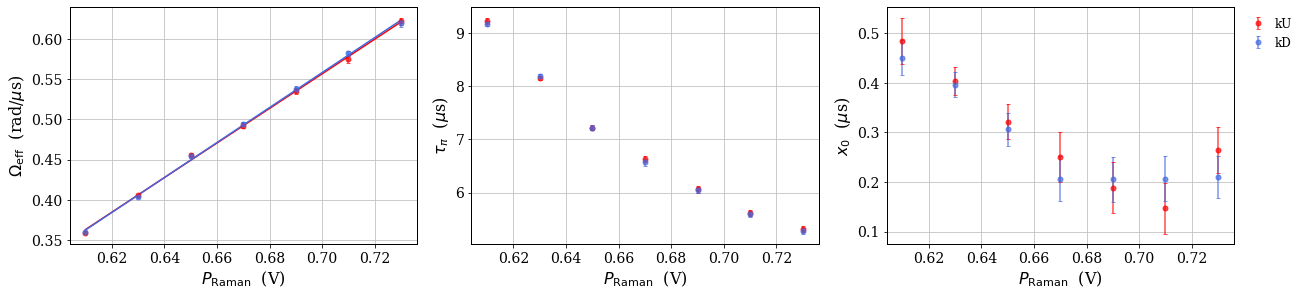

In [4]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': 'None', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': None, 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (1,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax     = iaxList[0]
nX      = SummaryDF[0][iax]['RamanPower'].size
Omega   = np.zeros((nSummary,2,nX)) ## [s,iErr,iX]
tau_pi  = np.zeros((nSummary,2,nX)) ## [s,iErr,iX]
xOffset = np.zeros((nSummary,2,nX)) ## [s,iErr,iX]

Model   = lm.models.LinearModel()

for s in range(nSummary):
    xData = SummaryDF[s][iax]['RamanPower'].to_numpy()

    Omega[s,0]   = SummaryDF[s][iax]['Omega'].to_numpy()
    Omega[s,1]   = SummaryDF[s][iax]['Omega_Err'].to_numpy()
    tau_pi[s,0]  = SummaryDF[s][iax]['taupi'].to_numpy()
    tau_pi[s,1]  = SummaryDF[s][iax]['taupi_Err'].to_numpy()
    xOffset[s,0] = SummaryDF[s][iax]['xOffset'].to_numpy()
    xOffset[s,1] = SummaryDF[s][iax]['xOffset_Err'].to_numpy()

    PlotOpts['Linestyle'] = 'None'
    PlotOpts['Marker']    = '.'
    PlotOpts['Color']     = Colors[s][0]
    PlotOpts['xLabel']    = r'$P_{\rm Raman}$  (V)'
    PlotOpts['yLabel']    = r'$\Omega_{\rm eff}$  (rad/$\mu$s)'
    PlotOpts['LegLabel']  = None
    iXUtils.CustomPlot(axs[0], PlotOpts, xData, Omega[s,0], Omega[s,1])
    PlotOpts['yLabel']    = r'$\tau_{\pi}$  ($\mu$s)'
    iXUtils.CustomPlot(axs[1], PlotOpts, xData, tau_pi[s,0], tau_pi[s,1])
    PlotOpts['yLabel']    = r'$x_0$  ($\mu$s)'
    PlotOpts['LegLabel']  = 'kU' if s == 0 else 'kD'
    iXUtils.CustomPlot(axs[2], PlotOpts, xData, xOffset[s,0], xOffset[s,1])

    PlotOpts['Linestyle'] = '-'
    PlotOpts['Marker']    = 'None'
    PlotOpts['Color']     = Colors[s][0]
    PlotOpts['yLabel']    = r'$\Omega_{\rm eff}$  (rad/$\mu$s)'
    PlotOpts['LegLabel']  = None
    Params = Model.guess(Omega[s,0], x=xData)
    Result = Model.fit(Omega[s,0], Params, x=xData)
    iXUtils.CustomPlot(axs[0], PlotOpts, xData, Result.best_fit)

    print('----------- Fit Results (s = {:}) -----------'.format(s))
    print(Result.fit_report(show_correl=False))
        
axs[2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
plt.show()

In [36]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [{'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13}]
RunLists = [[1,21], [22,42]]

Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet']]
nSummary = len(RunLists)
PRaman   = np.zeros(nSummary)
RamanTOF = np.zeros(nSummary)

SummaryDF = [[pd.DataFrame([]) for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, 'Rabi', RunList[0])
    RunPars.LoadRunParameters()
    PRaman[s] = RunPars.RamanPower
    RamanTOF[s] = RunPars.RamanTOF
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', 'Rabi')
    SummaryFilePrefix = 'Rabi-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][0]+'.txt')
        if os.path.exists(SummaryFilePath):
            print('Loading summary file: {}'.format(SummaryFilePath))
            SummaryDF[s][iax] = pd.read_csv(SummaryFilePath, sep='\t')
            SummaryDF[s][iax].sort_values(by=['RamanTOF'], inplace=True)
        else:
            print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Rabi\Rabi-Runs01-21-AnalysisSummary-Z.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Rabi\Rabi-Runs22-42-AnalysisSummary-Z.txt


----------- Fit Results (s = 0)-----------
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 3
    chi-square         = 8.6700e-04
    reduced chi-square = 4.8167e-05
    Akaike info crit   = -205.994853
    Bayesian info crit = -202.861285
[[Variables]]
    a: -0.00897336 +/- 0.00115844 (12.91%) (init = -0.008973363)
    b: -0.02935326 +/- 0.00479954 (16.35%) (init = -0.02935326)
    c:  0.51649177 +/- 0.00414266 (0.80%) (init = 0.5164918)
----------- Fit Results (s = 1)-----------
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 3
    chi-square         = 3.1757e-04
    reduced chi-square = 1.7643e-05
    Akaike info crit   = -227.086267
    Bayesian info crit = -223.952699
[[Variables]]
    a: -0.01598704 +/- 7.0110e-04 (4.39%) (init = -0.01598704)
    b: -0.0

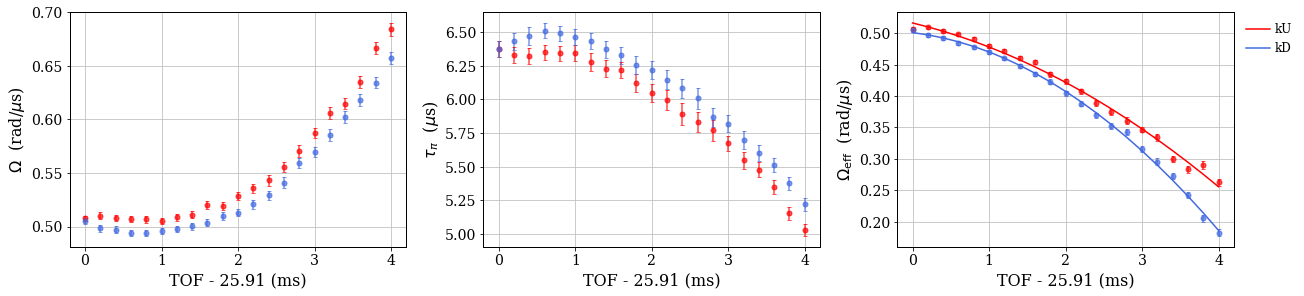

In [41]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': 'None', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': None, 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (1,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax     = iaxList[0]
nX      = SummaryDF[0][iax]['RamanTOF'].size
Omega   = np.zeros((nSummary,2,nX)) ## [s,iErr,iX]
Omega_eff = np.zeros((nSummary,2,nX)) ## [s,iErr,iX]
tau_pi  = np.zeros((nSummary,2,nX)) ## [s,iErr,iX]

deltak  = 2.*np.pi*RunPars.kUpFrequency
fkU     = 6.835382000E9
fkD     = 6.834023000E9
deltaD  = np.pi*(fkU - fkD)
v0      = deltaD/keff

Model   = lm.models.QuadraticModel()

for s in range(nSummary):
    TOF   = SummaryDF[s][iax]['RamanTOF'].to_numpy()
    TOF  -= TOF[0]
    xData = TOF*1.E3 

    Omega[s,0]   = SummaryDF[s][iax]['Omega'].to_numpy()
    Omega[s,1]   = SummaryDF[s][iax]['Omega_Err'].to_numpy()
    Omega_eff[s,0]   = np.sqrt(abs(SummaryDF[s][iax]['Omega'].to_numpy()**2 - (keff*gLocal*TOF*1.E-6)**2))
    Omega_eff[s,1]   = SummaryDF[s][iax]['Omega_Err'].to_numpy()
    tau_pi[s,0]  = SummaryDF[s][iax]['taupi'].to_numpy()
    tau_pi[s,1]  = SummaryDF[s][iax]['taupi_Err'].to_numpy()

    PlotOpts['Linestyle'] = 'None'
    PlotOpts['Marker']    = '.'
    PlotOpts['Color']     = Colors[s][0]
    PlotOpts['xLabel']    = 'TOF - 25.91 (ms)'
    PlotOpts['yLabel']    = r'$\Omega$  (rad/$\mu$s)'
    PlotOpts['LegLabel']  = None
    iXUtils.CustomPlot(axs[0], PlotOpts, xData, Omega[s,0], Omega[s,1])
    PlotOpts['yLabel']    = r'$\tau_{\pi}$  ($\mu$s)'
    iXUtils.CustomPlot(axs[1], PlotOpts, xData, tau_pi[s,0], tau_pi[s,1])
    PlotOpts['yLabel']    = r'$\Omega_{\rm eff}$  ($\mu$s)'
    iXUtils.CustomPlot(axs[2], PlotOpts, xData, Omega_eff[s,0], Omega_eff[s,1])

    PlotOpts['Linestyle'] = '-'
    PlotOpts['Marker']    = 'None'
    PlotOpts['Color']     = Colors[s][0]
    PlotOpts['yLabel']    = r'$\Omega_{\rm eff}$  (rad/$\mu$s)'
    PlotOpts['LegLabel']  = 'kU' if s == 0 else 'kD'
    Params = Model.guess(Omega_eff[s,0], x=xData)
    Result = Model.fit(Omega_eff[s,0], Params, x=xData)
    iXUtils.CustomPlot(axs[2], PlotOpts, xData, Result.best_fit)

    print('----------- Fit Results (s = {:})-----------'.format(s))
    print(Result.fit_report(show_correl=False))

axs[2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))

plt.show()

In [109]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [{'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10},
            {'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10},
            {'Month': 'August', 'Day': 10}]
RunLists = [[52,59], [44,51], [60,67], [12,19], [20,27], [28,35], [36,43]]
Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet']]
nSummary = len(RunLists)
tau_pi   = np.zeros(nSummary)
PRaman   = np.zeros(nSummary)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    tau_pi[s] = RunPars.RamanpiZ
    PRaman[s] = RunPars.RamanPower
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')                
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs52-59-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs52-59-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs44-51-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs44-51-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs60-67-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs60-67-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs12-19-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs12-19-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom 

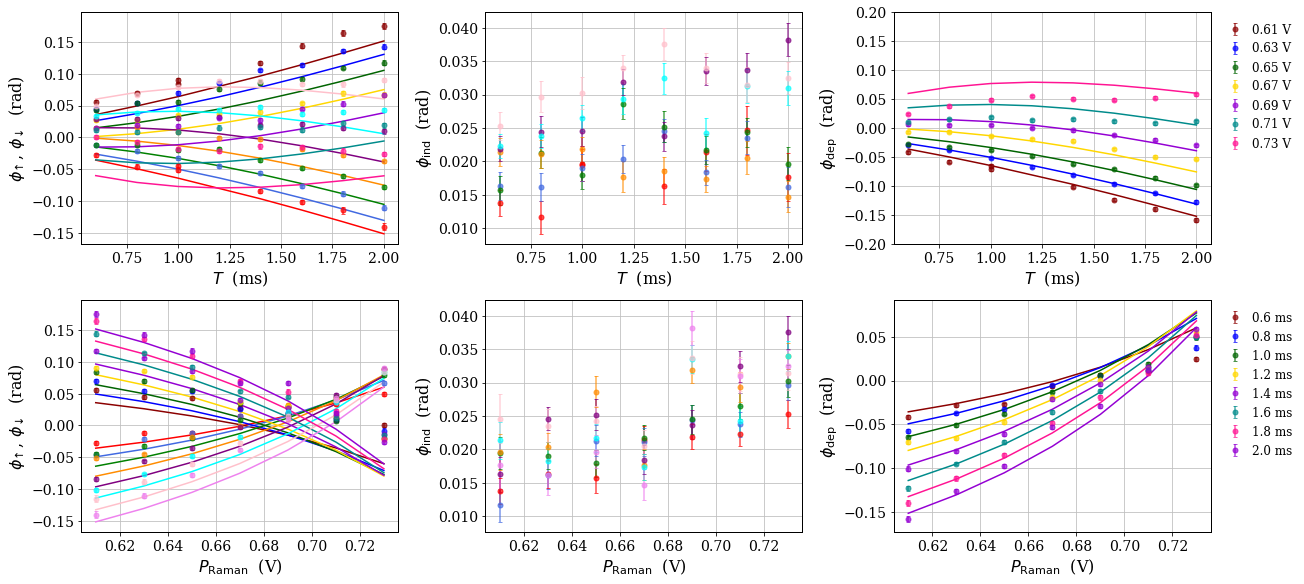

In [111]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': 'None', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax    = iaxList[0]
nT     = SummaryDF[0][iax][0]['RamanT'].size
phi    = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]
taupi0 = 6.0E-6
Omega0 = np.pi/taupi0

taupi_Test = 6.08E-6
OmegaModel = lambda P, t: (2.244*P - 1.001)*1.E6*(0.5165 - 0.02935*(t*1.E3) - 0.008973*(t*1.E3)**2)/0.5165
phiModel   = lambda T, tau, Omega1, Omega2, Omega3: keff*gLocal*(
    (T + 2.*tau)*(T + 1./Omega1*np.tan(Omega1*tau/2.) + 1./Omega3*np.tan(Omega3*tau/2.)) + 
    1.*tau*(1./(Omega1*np.tan(Omega1*tau)) - 2./(Omega2*np.tan(Omega2*tau)) + 1./(Omega3*np.tan(Omega3*tau))) -
    1.*(1./Omega1**2 - 2./Omega2**2 + 1./Omega3**2))

def DeltaPhi(x, tau, tauRef, Omega0, dOmega):
    """Model of the AI inertial phase deviation from the ideal one."""
    Omega1  = abs(Omega0)
    Omega2  = abs(Omega0*(1 - 1.*dOmega*x))
    Omega3  = abs(Omega0*(1 - 2.*dOmega*x))
    phi_ref = keff*gLocal*(x + 2.*tauRef)*(x + 4.*tauRef/np.pi)
    phi_g   = keff*gLocal*((x + 2.*tau)*(x + 1./Omega1*np.tan(Omega1*tau/2.) + 1./Omega3*np.tan(Omega3*tau/2.))
        + tau*(1./(Omega1*np.tan(Omega1*tau)) - 2./(Omega2*np.tan(Omega2*tau)) + 1./(Omega3*np.tan(Omega3*tau)))
        - (1./Omega1**2 - 2./Omega2**2 + 1./Omega3**2))
#     phi_v   = (keff*v1 - omega1)*(1./Omega3*np.tan(Omega3*tau/2.) - 1./Omega1*np.tan(Omega1*tau/2.))
    return phi_g - phi_ref

Model = lm.Model(DeltaPhi)

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()
 
    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['phi0'].to_numpy() - (1.-2.*ik)*Seff*gLocal
        phi[s,ik,1] = SummaryDF[s][iax][ik]['phi0_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0])
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['Marker']    = '.'
    PlotOpts['Linestyle'] = 'None'
    PlotOpts['xLabel']    = r'$T$  (ms)'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[s][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']     = Colors[s][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']    = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']     = Colors[s][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel']  = '{:.2f} V'.format(PRaman[s])
    PlotOpts['Color']     = Colors[s][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

#     phiRef = phiModel(RamanT, 0.5*taupi0, Omega0, Omega0, Omega0)
    phiRef = Seff*gLocal
    phiAI  = phiModel(RamanT, 0.5*taupi_Test, OmegaModel(PRaman[s], 0.*RamanT), OmegaModel(PRaman[s], 1.*RamanT), OmegaModel(PRaman[s], 2.*RamanT))
    PlotOpts['Marker']    = 'None'
    PlotOpts['Linestyle'] = '-'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[s][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3,  phiAI - phiRef)
    PlotOpts['Color']     = Colors[s][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3,-(phiAI - phiRef))
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phiAI - phiRef)

#     Params = lm.Parameters()
#     Params.add_many(
#         lm.Parameter('tau',    value=0.5*tau_pi[s], min=0., vary=True),
#         lm.Parameter('tauRef', value=0.5*tau_pi[s], min=0., vary=False),
#         lm.Parameter('Omega0', value=OmegaModel(PRaman[s], 0.E-3), min=0., vary=True),
#         lm.Parameter('dOmega', value=4., vary=True))
#     Result = Model.fit(phiAI - phiRef, Params, x=RamanT)
#     PlotOpts['Marker']    = 'None'
#     PlotOpts['Linestyle'] = '-'
#     iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, Result.best_fit)

#     print('----------- Fit Results (s = {:})-----------'.format(s))
#     print(Result.fit_report(show_correl=False))

for t in range(nT):
    PlotOpts['Marker']    = '.'
    PlotOpts['Linestyle'] = 'None'
    PlotOpts['xLabel']    = r'$P_{\rm Raman}$  (V)'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[t][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, PRaman, phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']     = Colors[t][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, PRaman, phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']    = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']     = Colors[t][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, PRaman, phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel']  = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']     = Colors[t][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, PRaman, phi[:,3,0,t], phi[:,3,1,t])

    phiRef = phiModel(RamanT[t], 0.5*taupi0, Omega0, Omega0, Omega0)
    phiAI  = phiModel(RamanT[t], 0.5*taupi_Test, OmegaModel(PRaman, 0.*RamanT[t]), OmegaModel(PRaman, 1.*RamanT[t]), OmegaModel(PRaman, 2.*RamanT[t]))
    PlotOpts['Marker']    = 'None'
    PlotOpts['Linestyle'] = '-'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[t][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, PRaman,  phiAI - phiRef)
    PlotOpts['Color']     = Colors[t][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, PRaman,-(phiAI - phiRef))
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    iXUtils.CustomPlot(axs[1,2], PlotOpts, PRaman,  phiAI - phiRef)

axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[0,2].set_ylim((-0.2,0.2))

plt.show()

In [76]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [{'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10},
            {'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10},
            {'Month': 'August', 'Day': 10}, {'Month': 'August', 'Day': 10}]
RunLists = [[68,75], [76,83], [84,91], [92,99], [100,107], [108,115], [116,123], [124,131]]
Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet'], ['gray','black']]
nSummary = len(RunLists)
tau_pi   = np.zeros(nSummary)
PRaman   = np.zeros(nSummary)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    tau_pi[s] = RunPars.RamanpiZ
    PRaman[s] = RunPars.RamanPower
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')                
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs68-75-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs68-75-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs76-83-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs76-83-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs84-91-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs84-91-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs92-99-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\10\PostProcessed\Raman\Raman-Runs92-99-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom 

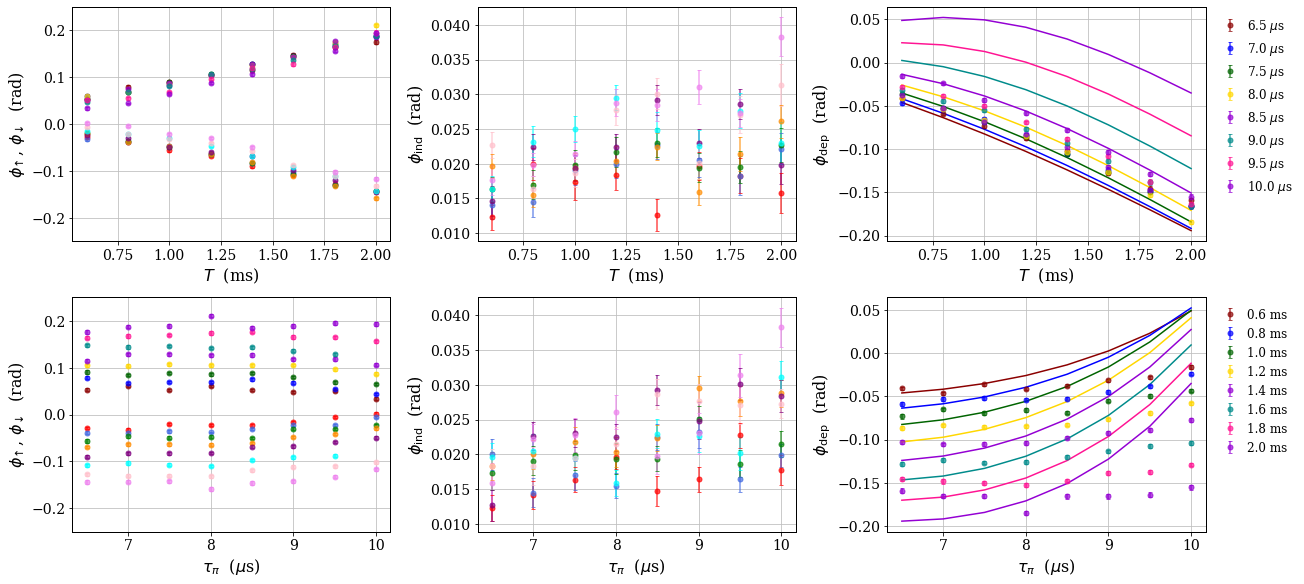

In [82]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': 'None', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax = iaxList[0]
nT  = SummaryDF[0][iax][0]['RamanT'].size
phi = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]
taupi0 = 6.0E-6
Omega0 = np.pi/taupi0

taupi_Test = 6.08E-6
OmegaModel = lambda P, t: (2.244*P - 1.001)*1.E6*(0.5165 - 0.02935*(t*1.E3) - 0.008973*(t*1.E3)**2)/0.5165
phiModel   = lambda T, tau, Omega1, Omega2, Omega3: keff*gLocal*(
    (T + 2.*tau)*(T + 1./Omega1*np.tan(Omega1*tau/2.) + 1./Omega3*np.tan(Omega3*tau/2.)) + 
    1.*tau*(1./(Omega1*np.tan(Omega1*tau)) - 2./(Omega2*np.tan(Omega2*tau)) + 1./(Omega3*np.tan(Omega3*tau))) -
    1.*(1./Omega1**2 - 2./Omega2**2 + 1./Omega3**2))

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()

    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['phi0'].to_numpy() - (1.-2.*ik)*Seff*gLocal
        phi[s,ik,1] = SummaryDF[s][iax][ik]['phi0_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0]) % (-2.*np.pi)
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['Marker']    = '.'
    PlotOpts['Linestyle'] = 'None'
    PlotOpts['xLabel']    = r'$T$  (ms)'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[s][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']     = Colors[s][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']    = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']     = Colors[s][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel']  = r'{:.1f} $\mu$s'.format(tau_pi[s]*1.E6)
    PlotOpts['Color']     = Colors[s][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

#     Omega0 = np.pi/tau_pi[s]
#     phiRef = phiModel(RamanT, 0.5*tau_pi[s], Omega0, Omega0, Omega0)
    phiRef = Seff*gLocal
    phiAI  = phiModel(RamanT, 0.5*tau_pi[s], OmegaModel(PRaman[s], 0.*RamanT), OmegaModel(PRaman[s], 1.*RamanT), OmegaModel(PRaman[s], 2.*RamanT))
    PlotOpts['Marker']    = 'None'
    PlotOpts['Linestyle'] = '-'
    PlotOpts['LegLabel']  = None
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phiAI - phiRef)

for t in range(nT):
    PlotOpts['Marker']    = '.'
    PlotOpts['Linestyle'] = 'None'
    PlotOpts['xLabel']    = r'$\tau_{\pi}$  ($\mu$s)'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[t][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']     = Colors[t][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']    = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']     = Colors[t][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, tau_pi*1.E6, phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel']  = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']     = Colors[t][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tau_pi*1.E6, phi[:,3,0,t], phi[:,3,1,t])

    Omega0 = np.pi/tau_pi
    phiRef = phiModel(RamanT[t], 0.5*tau_pi, Omega0, Omega0, Omega0)
    phiAI  = phiModel(RamanT[t], 0.5*tau_pi, OmegaModel(PRaman[t], 0.*RamanT[t]), OmegaModel(PRaman[t], 1.*RamanT[t]), OmegaModel(PRaman[t], 2.*RamanT[t]))
    PlotOpts['Marker']    = 'None'
    PlotOpts['Linestyle'] = '-'
    PlotOpts['LegLabel']  = None
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tau_pi*1.E6, phiAI - phiRef)

axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[0,0].set_ylim((-0.25,0.25))
axs[1,0].set_ylim((-0.25,0.25))

plt.show()    

In [112]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [{'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11},
            {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11},
            {'Month': 'August', 'Day': 11}]
RunLists = [ [33,40], [41,48], [49,56], [1,8], [9,16], [17,24], [25,32]]
Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet'], ['gray','black']]
nSummary = len(RunLists)
tau_pi   = np.zeros(nSummary)
PRaman   = np.zeros(nSummary)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    tau_pi[s] = RunPars.RamanpiZ
    PRaman[s] = RunPars.RamanPower
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')                
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs33-40-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs33-40-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs41-48-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs41-48-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs49-56-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs49-56-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs01-08-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs01-08-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom 

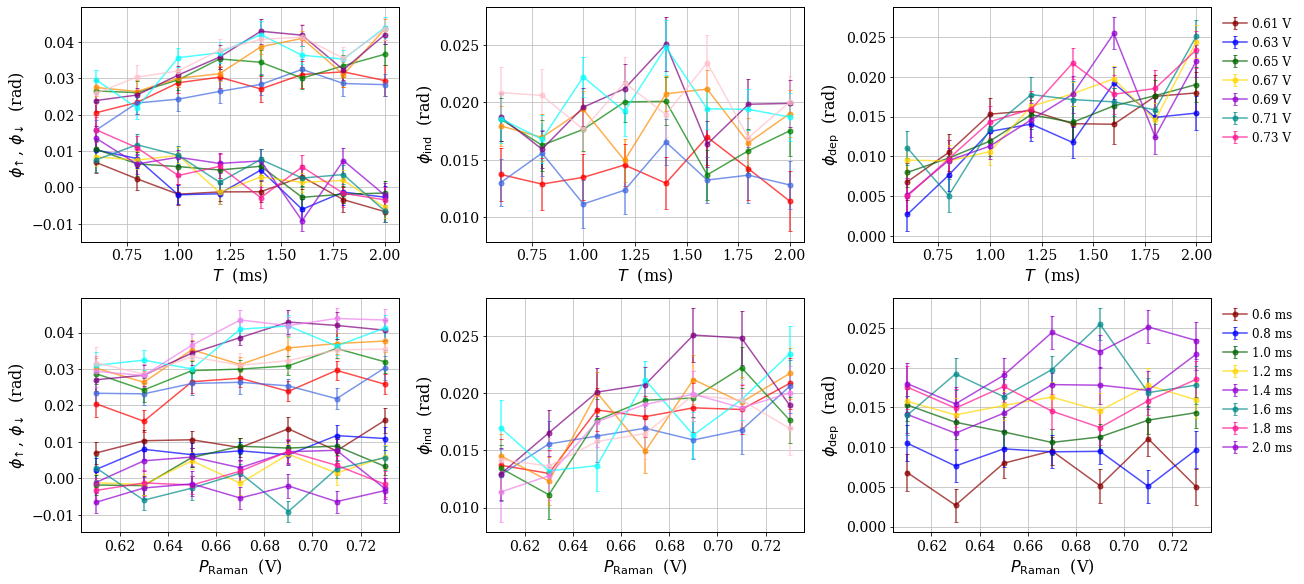

In [113]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax    = iaxList[0]
nT     = SummaryDF[0][iax][0]['RamanT'].size
phi    = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()

    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['xOffset'].to_numpy()
        phi[s,ik,1] = SummaryDF[s][iax][ik]['xOffset_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0])
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['xLabel']   = r'$T$  (ms)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[s][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']    = Colors[s][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[s][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = '{:.2f} V'.format(PRaman[s])
    PlotOpts['Color']    = Colors[s][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

for t in range(nT):
    PlotOpts['xLabel']   = r'$P_{\rm Raman}$  (V)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[t][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, PRaman, phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']    = Colors[t][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, PRaman, phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[t][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, PRaman, phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']    = Colors[t][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, PRaman, phi[:,3,0,t], phi[:,3,1,t])
        
axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))

plt.show()    

In [114]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList  = [{'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11},
             {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11},
             {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}]
RunLists  = [[137,144], [145,152], [153,160], [161,168], [129,136], [169,176], [177,184], [185,192], [193,200]]
Colors    = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet'], ['gray','black']]
nSummary  = len(RunLists)
deltaDiff = np.zeros(nSummary)
SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    deltaDiff[s] = RunPars.deltaDiff
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')                
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs137-144-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs137-144-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs145-152-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs145-152-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs153-160-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs153-160-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs161-168-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\11\PostProcessed\Raman\Raman-Runs161-168-AnalysisSummary-Z-kD.txt
Loading summary 

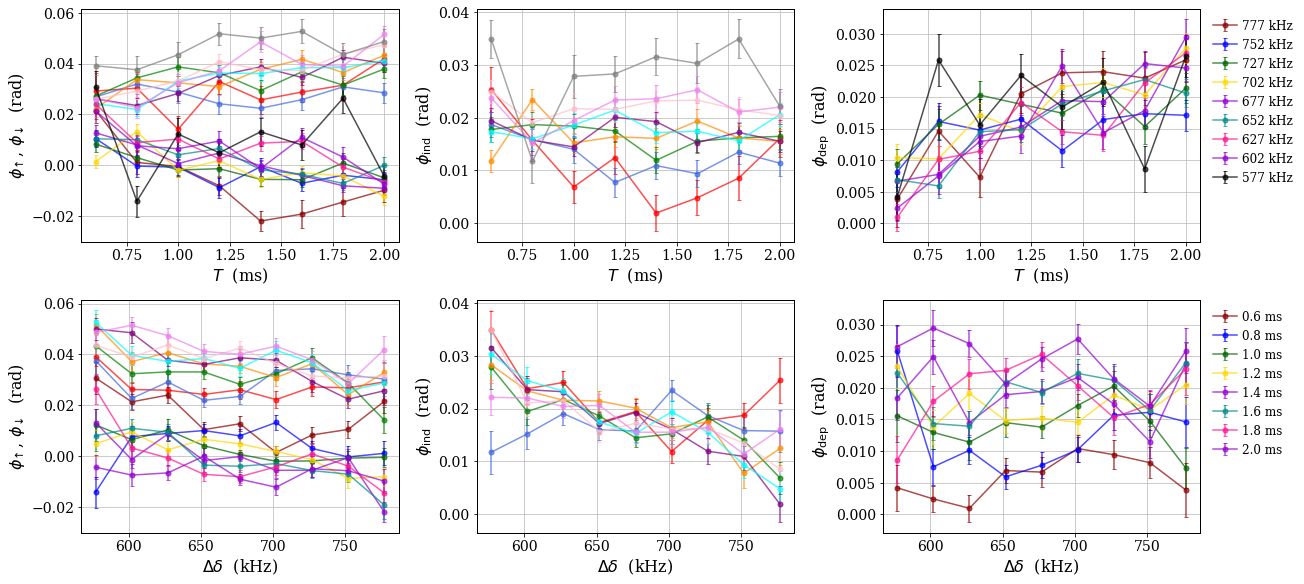

In [115]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax    = iaxList[0]
nT     = SummaryDF[0][iax][0]['RamanT'].size
phi    = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()

    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['xOffset'].to_numpy()
        phi[s,ik,1] = SummaryDF[s][iax][ik]['xOffset_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0])
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['xLabel']   = r'$T$  (ms)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[s][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']    = Colors[s][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[s][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = '{:.0f} kHz'.format(deltaDiff[s]*1.E-3/(2.*np.pi))
    PlotOpts['Color']    = Colors[s][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

for t in range(nT):
    PlotOpts['xLabel']   = r'$\Delta \delta$  (kHz)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[t][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, deltaDiff*1.E-3/(2.*np.pi), phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']    = Colors[t][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, deltaDiff*1.E-3/(2.*np.pi), phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[t][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, deltaDiff*1.E-3/(2.*np.pi), phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']    = Colors[t][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, deltaDiff*1.E-3/(2.*np.pi), phi[:,3,0,t], phi[:,3,1,t])
        
axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))

plt.show()    

In [136]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [{'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11},
            {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11},
            {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11}, {'Month': 'August', 'Day': 11},
            {'Month': 'August', 'Day': 11}]
RunLists = [[57,64], [65,72], [105,112], [73,80], [113,120], [1,8], [121,128], [81,88], [89,96], [97,104]]

DateList = [{'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12},
            {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}, 
            {'Month': 'August', 'Day': 12},{'Month': 'August', 'Day': 12}]
RunLists = [[9,68], [17,70], [25,72], [33,74], [1,66], [41,76], [49,78], [57,80]]

Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet'],
            ['gray','black']]
nColors  = len(Colors)
nSummary = len(RunLists)
tau_pi   = np.zeros(nSummary)
PRaman   = np.zeros(nSummary)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    tau_pi[s] = RunPars.RamanpiZ
    PRaman[s] = RunPars.RamanPower
    alpha0 = 2.*np.pi*RunPars.kUpChirpRate

    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')
                SummaryDF[s][iax][ik].sort_values(by=['RamanT'], inplace=True)
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs09-68-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs09-68-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs17-70-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs17-70-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs25-72-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs25-72-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs33-74-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs33-74-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom 

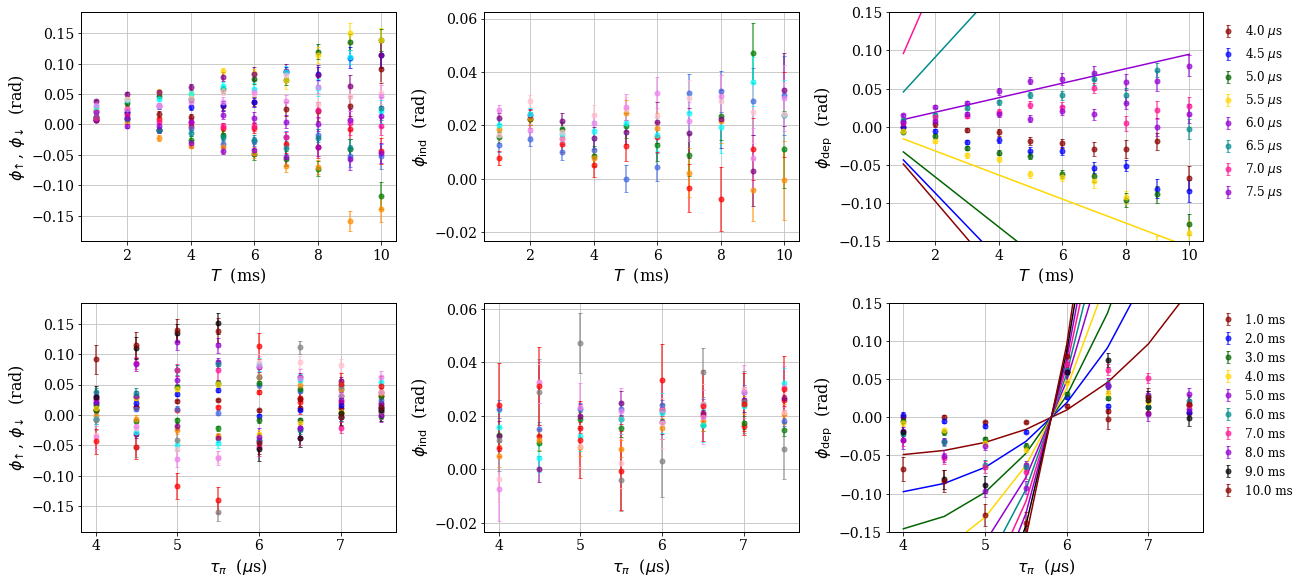

In [192]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax = iaxList[0]
nT  = SummaryDF[0][iax][0]['RamanT'].size
phi = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]
taupi0 = 6.0E-6
Omega0 = np.pi/taupi0

taupi_Test = 6.08E-6
OmegaModel = lambda P, t: (2.244*P - 1.001)*1.E6#*(1. - 0.005*(t*1.E3))
phiModel   = lambda T, tau, Omega1, Omega2, Omega3: alpha0*(
    (T + 2.*tau)*(T + 1./Omega1*np.tan(Omega1*tau/2.) + 1./Omega3*np.tan(Omega3*tau/2.)) + 
    1.*tau*(1./(Omega1*np.tan(Omega1*tau)) - 2./(Omega2*np.tan(Omega2*tau)) + 1./(Omega3*np.tan(Omega3*tau))) -
    1.*(1./Omega1**2 - 2./Omega2**2 + 1./Omega3**2))

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()

    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['xOffset'].to_numpy()
        phi[s,ik,1] = SummaryDF[s][iax][ik]['xOffset_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0])
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['Marker']    = '.'
    PlotOpts['Linestyle'] = 'None'
    PlotOpts['xLabel']    = r'$T$  (ms)'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']     = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']    = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']     = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel']  = r'{:.1f} $\mu$s'.format(tau_pi[s]*1.E6)
    PlotOpts['Color']     = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

    phiRef = alpha0*Seff/keff
#     phiAI  = phiModel(RamanT, 0.5*tau_pi[s], OmegaModel(PRaman[s], 0.*RamanT), OmegaModel(PRaman[s], 1.*RamanT), OmegaModel(PRaman[s], 2.*RamanT))
    ctau   = 1.005
    cOmega = [1.000, 1.000, 1.000]
    phiAI  = phiModel(RamanT, ctau*0.5*tau_pi[s], cOmega[0]*Omega0, cOmega[1]*Omega0, cOmega[2]*Omega0)
    PlotOpts['Marker']    = 'None'
    PlotOpts['Linestyle'] = '-'
    PlotOpts['LegLabel']  = None
#     PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
#     PlotOpts['Color']     = Colors[s%nColors][0]
#     iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3,  phiAI - phiRef)
#     PlotOpts['Color']     = Colors[s%nColors][1]
#     iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3,-(phiAI - phiRef))
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phiAI - phiRef)

for t in range(nT):
    PlotOpts['Marker']    = '.'
    PlotOpts['Linestyle'] = 'None'
    PlotOpts['xLabel']    = r'$\tau_{\pi}$  ($\mu$s)'
    PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel']  = None
    PlotOpts['Color']     = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']     = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']    = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']     = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, tau_pi*1.E6, phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel']  = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']     = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tau_pi*1.E6, phi[:,3,0,t], phi[:,3,1,t])

    phiRef = alpha0*(RamanT[t] + tau_pi)*(RamanT[t] + 2.*tau_pi/np.pi)
#     phiAI  = phiModel(RamanT, 0.5*tau_pi[s], OmegaModel(PRaman[s], 0.*RamanT), OmegaModel(PRaman[s], 1.*RamanT), OmegaModel(PRaman[s], 2.*RamanT))
    ctau   = 1.005
    cOmega = [1.000, 1.000, 1.000]
    phiAI  = phiModel(RamanT[t], ctau*0.5*tau_pi, cOmega[0]*Omega0, cOmega[1]*Omega0, cOmega[2]*Omega0)
    PlotOpts['Marker']    = 'None'
    PlotOpts['Linestyle'] = '-'
    PlotOpts['LegLabel']  = None
#     PlotOpts['yLabel']    = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
#     PlotOpts['Color']     = Colors[s%nColors][0]
#     iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3,  phiAI - phiRef)
#     PlotOpts['Color']     = Colors[s%nColors][1]
#     iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3,-(phiAI - phiRef))
    PlotOpts['yLabel']    = r'$\phi_{\rm dep}$  (rad)'
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tau_pi*1.E6, phiAI - phiRef)

axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[0,2].set_ylim((-0.15,0.15))
axs[1,2].set_ylim((-0.15,0.15))

plt.show()

In [150]:
print(phiAI)
print(phiRef)

[  159.48130583   634.81276985  1425.99801148  2533.0370307
  3955.92982754  5694.67640198  7749.27675402 10119.73088366
 12806.03879091 15808.20047577]
[  159.48130585   634.81276984  1425.99801122  2533.03703038
  3955.92982763  5694.67640198  7749.27675441 10119.73088002
 12806.03878861 15808.20047136]
[-1.58797206e-08  1.68810175e-08  2.59750550e-07  3.20503659e-07
 -9.50276444e-08 -6.28460839e-09 -3.93823029e-07  3.64516745e-06
  2.30505248e-06  4.41091106e-06]


In [134]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [{'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13},
            {'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13},
            {'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13},
            {'Month': 'August', 'Day': 13}, {'Month': 'August', 'Day': 13}]
RunLists = [[101,110], [91,100], [81,90], [71,80], [61,70], [1,10], [11,20], [21,30], [31,40], [41,50], [51,60]]

Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet'],
            ['gray','black']]
nColors  = len(Colors)
nSummary = len(RunLists)
tau_pi   = np.zeros(nSummary)
PRaman   = np.zeros(nSummary)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    tau_pi[s] = RunPars.RamanpiZ
    PRaman[s] = RunPars.RamanPower
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')
                SummaryDF[s][iax][ik].sort_values(by=['RamanT'], inplace=True)
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs101-110-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs101-110-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs91-100-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs91-100-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs81-90-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs81-90-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs71-80-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\13\PostProcessed\Raman\Raman-Runs71-80-AnalysisSummary-Z-kD.txt
Loading summary file: C:\i

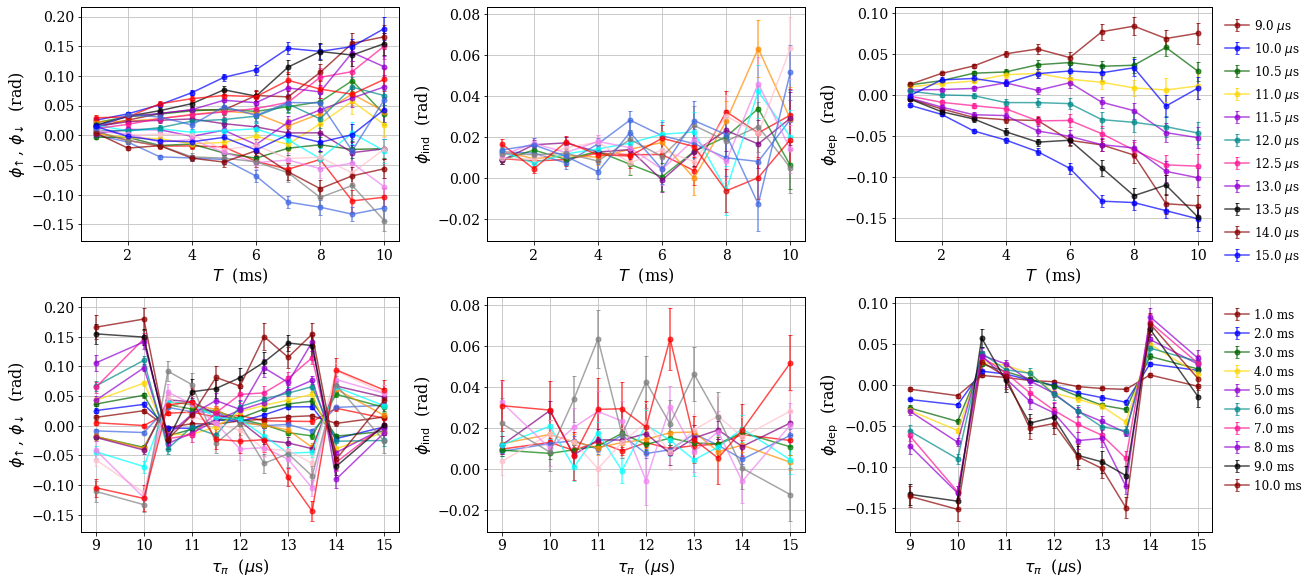

In [135]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax = iaxList[0]
nT  = SummaryDF[0][iax][0]['RamanT'].size
phi = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()

    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['xOffset'].to_numpy()
        phi[s,ik,1] = SummaryDF[s][iax][ik]['xOffset_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0])
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['xLabel']   = r'$T$  (ms)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']    = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = r'{:.1f} $\mu$s'.format(tau_pi[s]*1.E6)
    PlotOpts['Color']    = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

for t in range(nT):
    PlotOpts['xLabel']   = r'$\tau_{\pi}$  ($\mu$s)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']    = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, tau_pi*1.E6, phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']    = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tau_pi*1.E6, phi[:,3,0,t], phi[:,3,1,t])
        
axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))

plt.show()

In [39]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

DateList = [{'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12},
            {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}, 
            {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}, {'Month': 'August', 'Day': 12}]
RunLists = [[81,88], [89,96], [97,104], [105,112], [113,120], [121,128], [129,136], [137,144], [145,152]]

Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet'],
            ['gray','black']]
nColors  = len(Colors)
nSummary = len(RunLists)
RamanTOF = np.zeros(nSummary)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    RamanTOF[s] = RunPars.RamanTOF
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')
                SummaryDF[s][iax][ik].sort_values(by=['RamanT'], inplace=True)
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs81-88-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs81-88-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs89-96-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs89-96-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs97-104-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs97-104-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs105-112-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\12\PostProcessed\Raman\Raman-Runs105-112-AnalysisSummary-Z-kD.txt
Loading summary file: C:\i

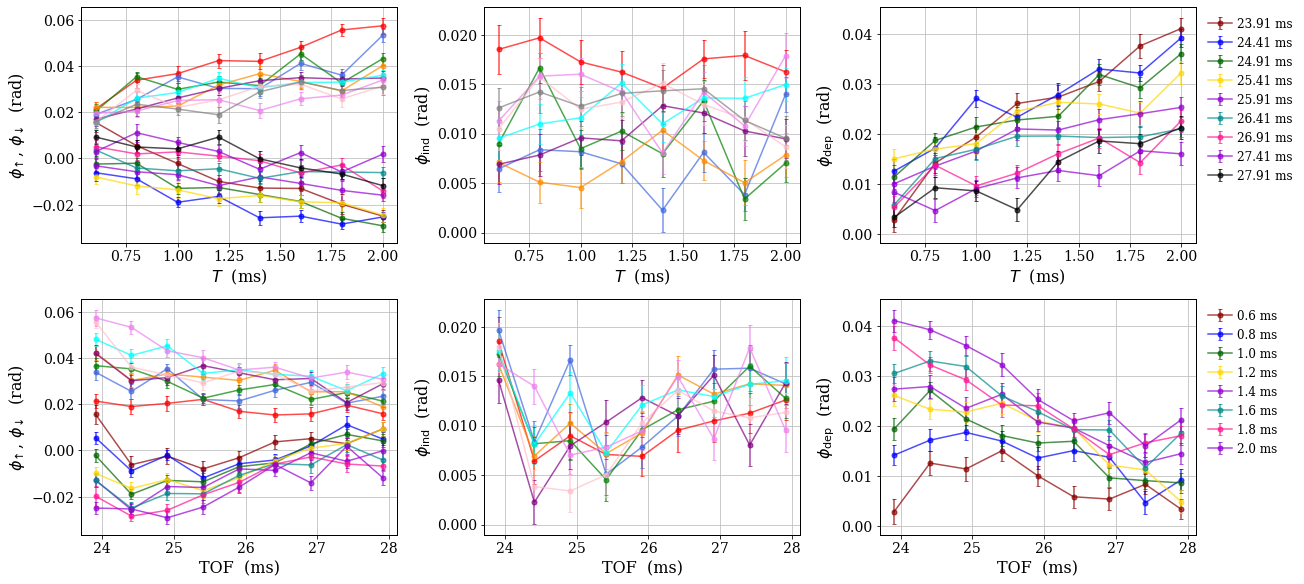

In [41]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax = iaxList[0]
nT  = SummaryDF[0][iax][0]['RamanT'].size
phi = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()

    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['xOffset'].to_numpy()
        phi[s,ik,1] = SummaryDF[s][iax][ik]['xOffset_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0])
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['xLabel']   = r'$T$  (ms)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']    = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = r'{:.2f} ms'.format(RamanTOF[s]*1.E3)
    PlotOpts['Color']    = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

for t in range(nT):
    PlotOpts['xLabel']   = 'TOF  (ms)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, RamanTOF*1.E3, phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']    = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, RamanTOF*1.E3, phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, RamanTOF*1.E3, phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']    = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, RamanTOF*1.E3, phi[:,3,0,t], phi[:,3,1,t])
        
axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))

plt.show()

In [9]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

# DateList = [{'Month': 'August', 'Day': 17}, {'Month': 'August', 'Day': 17}, {'Month': 'August', 'Day': 17},
#             {'Month': 'August', 'Day': 17}, {'Month': 'August', 'Day': 17}]
# RunLists = [[7,12], [13,18], [1,6], [19,24], [25,30]]

DateList = [{'Month': 'August', 'Day': 17}, {'Month': 'August', 'Day': 17}, {'Month': 'August', 'Day': 17},
            {'Month': 'August', 'Day': 17}, {'Month': 'August', 'Day': 17}]
RunLists = [[31,36], [37,42], [43,48], [49,54], [55,60]]

Colors   = [['red', 'darkred'], ['royalblue', 'blue'], ['green','darkgreen'], ['darkorange','gold'],
            ['purple','darkviolet'], ['cyan','darkcyan'], ['pink','deeppink'], ['violet','darkviolet'],
            ['gray','black']]
nColors  = len(Colors)
nSummary = len(RunLists)
tau_pi   = np.zeros(nSummary)
PRaman   = np.zeros(nSummary)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()
    tau_pi[s] = RunPars.RamanpiZ
    PRaman[s] = RunPars.RamanPower
    
    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')
                SummaryDF[s][iax][ik].sort_values(by=['RamanT'], inplace=True)
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs31-36-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs31-36-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs37-42-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs37-42-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs43-48-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs43-48-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs49-54-AnalysisSummary-Z-kU.txt
Loading summary file: C:\iXAtom Desktop\Data 2020\August\17\PostProcessed\Raman\Raman-Runs49-54-AnalysisSummary-Z-kD.txt
Loading summary file: C:\iXAtom 

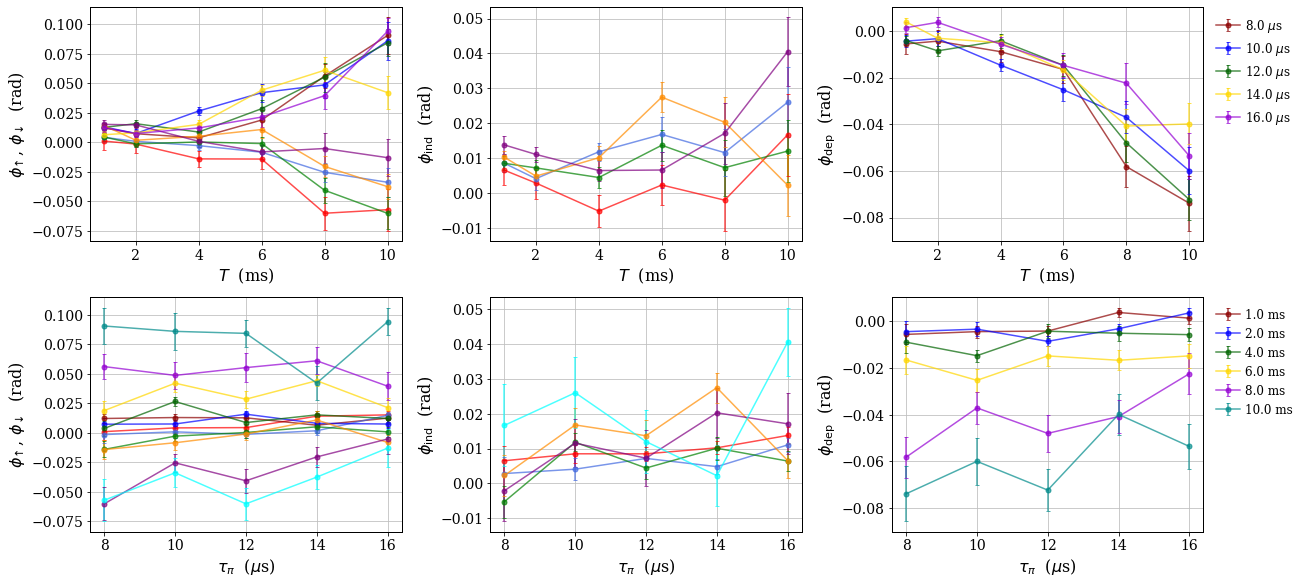

In [10]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================

## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=10)
plt.rc('legend', fontsize=12, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

iax = iaxList[0]
nT  = SummaryDF[0][iax][0]['RamanT'].size
phi = np.zeros((nSummary,4,2,nT)) ## [iP,ik,iErr,iT]

for s in range(nSummary):
    RamanT = SummaryDF[s][iax][0]['RamanT'].to_numpy()
    Seff   = SummaryDF[s][iax][0]['Seff'].to_numpy()

    for ik in range(2):
        phi[s,ik,0] = SummaryDF[s][iax][ik]['xOffset'].to_numpy()
        phi[s,ik,1] = SummaryDF[s][iax][ik]['xOffset_Err'].to_numpy()

    phi[s,2,0] = 0.5*(phi[s,0,0] + phi[s,1,0])
    phi[s,3,0] = 0.5*(phi[s,0,0] - phi[s,1,0])
    phi[s,2,1] = 0.5*np.sqrt(phi[s,0,1]**2 + phi[s,1,1]**2)
    phi[s,3,1] = phi[s,2,1]

    PlotOpts['xLabel']   = r'$T$  (ms)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,0,0], phi[s,0,1])
    PlotOpts['Color']    = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, RamanT*1.E3, phi[s,1,0], phi[s,1,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[s%nColors][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, RamanT*1.E3, phi[s,2,0], phi[s,2,1])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = r'{:.1f} $\mu$s'.format(tau_pi[s]*1.E6)
    PlotOpts['Color']    = Colors[s%nColors][1]
    iXUtils.CustomPlot(axs[0,2], PlotOpts, RamanT*1.E3, phi[s,3,0], phi[s,3,1])

for t in range(nT):
    PlotOpts['xLabel']   = r'$\tau_{\pi}$  ($\mu$s)'
    PlotOpts['yLabel']   = r'$\phi_{\!\uparrow}$, $\phi_{\!\downarrow}$  (rad)'
    PlotOpts['LegLabel'] = None
    PlotOpts['Color']    = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,0,0,t], phi[:,0,1,t])
    PlotOpts['Color']    = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tau_pi*1.E6, phi[:,1,0,t], phi[:,1,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm ind}$  (rad)'
    PlotOpts['Color']    = Colors[t%nColors][0]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, tau_pi*1.E6, phi[:,2,0,t], phi[:,2,1,t])
    PlotOpts['yLabel']   = r'$\phi_{\rm dep}$  (rad)'
    PlotOpts['LegLabel'] = '{:.1f} ms'.format(RamanT[t]*1.E3)
    PlotOpts['Color']    = Colors[t%nColors][1]
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tau_pi*1.E6, phi[:,3,0,t], phi[:,3,1,t])
        
axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))

plt.show()